#### VISCID BURGERS EQUATION 1D
Let $\Omega = (-1 , 1)^2$ and $\nu > 0 $:

$$
    \begin{cases}
        u_t + u u_{x} - \nu u_{xx} &= 0, \text{ in } \Omega,\\
        u(0, x) &= -\sin(\pi x) \text{ in } (-1, 1),\\
        u(t, -1) = u(t, 1) &= 0 \text{ in } (0, 1).
    \end{cases}
$$

#### PDE DATA
$$
    \begin{split}
        g(x,t) &= \left[ -\int_{-\infty}^{+\infty} \sin(\pi(x-\eta)) f(x-\eta) \exp\left(-\frac{\eta^2}{4\nu t}\right) d \eta \middle/ \int_{-\infty}^{+\infty} f(x-\eta) \exp\left(-\frac{\eta^2}{4\nu t}\right) d \eta \right]\\
        f(y) &= \exp \left[-\frac{\cos(\pi y)}{2 \pi \nu}\right]
    \end{split}
$$

#### EXPERIMENTS
Experiment 1: $\nu = 0.05$, $p=\infty$;

Experiment 2: $\nu = 0.05$, $p=2$;

In [1]:
import numpy as np
import sys
import json
sys.path.insert(1, 'C:/Users/philh/Notebooks/thesis_framework/')
from differentiation import Differentiation
from cubature import Cubature
from benchmark import Benchmark
from utilities import matmul, data_axes, leg_bary, laplacian, inverse_lu, mui_lp_ext, cart, pullback, hyper_rect
prefix = None#"viscid_burgers_equation"

#### CUBATURE AND DIFFERENTIATION

In [2]:
# DOMAIN #
deg_d = [20, 20]

cuba_d = Cubature(deg_d, points="Legendre") # for Lobatto points choose points="Lobatto"
w_d = cuba_d.leja_weights
xs_d = cuba_d.leja_axes
xs_plt_d = cuba_d.axes

bary = cuba_d.leja_axes_bary
diff = Differentiation(xs_d, bary)
dt, dx = diff.nabla

# BOUNDARY #
deg_b = [100]
cuba_b = Cubature(deg_b)
w_b = cuba_b.leja_weights
xs_b = cuba_b.leja_axes
xs_plt_b = cuba_b.axes

#### LAPLACIAN OPERATORS

In [3]:
I = np.eye(len(w_d))
n_d = np.max(deg_d)

W_d = np.diag(w_d)
W_d_inv = np.linalg.inv(W_d)

M_1, M_1_inv = laplacian([dt, dx], [W_d_inv]*2 , [W_d]*2)
M_1_s, _ = laplacian([dt, dx], [W_d_inv]*2, [W_d]*2, weak=True)

M_1_mod = (M_1 + I/n_d**2)
M_1_s_mod = n_d*M_1_s

W_b = np.diag(w_b)

In [4]:
# ABSOLUTE ERROR OF OPERATOR NORM #
print(abs(np.linalg.norm(M_1)-1.0))
print(abs(np.linalg.norm(M_1_s)-1.0))

0.31452544140417626
0.19633107365461933


#### PULLBACK

In [5]:
phi, dphi = hyper_rect(np.array([[0.0, 1.0], [-1.0, 1.0]]))
diff.nabla = pullback(diff.nabla, dphi, cuba_d.leja_grid)
dt, dx = diff.nabla
dx2 = diff.diffs(np.array([[0,2]]))[0]
phi_grid_plt_d = np.array([phi(_) for _ in cuba_d.grid])
#phi_grid_d = np.array([phi(_) for _ in cuba_d.leja_grid])

#### PDE DATA

In [6]:
nu = 0.1
x_h, w_h = np.polynomial.hermite.hermgauss(300)

def u_0(t, x):
    return 0*abs(t)+0*abs(x)

def u_1(t, x):
    return -np.sin(np.pi*x)+0*abs(t)

def f(y):
    return np.exp(-np.cos(np.pi*y)/(2*np.pi*nu))
            
def u(t, x):
    s = np.sqrt(4*nu*t)
    x_m = np.ones_like(x_h)*x-s*x_h
    int1 = -np.sum(np.sin(np.pi*x_m)*f(x_m)*w_h)
    int2 = np.sum(f(x_m)*w_h)
    return int1/int2

def gt(t, x):
    t, x = phi([t, x])
    
    if np.isscalar(t) & np.isscalar(x):
        return u(t, x)
    else:
        res = np.zeros_like(t)
        for i in range(len(t)):
            res[i] = u(t[i], x[i])
        return res

#### $l^p$ DEGREE AND BENCHMARK INITIALIZATION

In [7]:
# l^p #
p = 2
mui = mui_lp_ext(deg_d, p)

# BENCHMARK #
test_xs = [np.linspace(-1.0, 1.0, 249)]*2
data = data_axes(test_xs, mui).T
bm = Benchmark(gt, test_xs, data)
eval_gt = bm.eval_gt()
bm.plot_gt(prefix=prefix)
print(f'L^2 norm: {np.mean(np.array(eval_gt)**2)**0.5}')
print(f'L^inf norm: {np.max(abs(np.array(eval_gt)))}')

L^2 norm: 0.4453491013616212
L^inf norm: 1.0


#### PDE DATA RESOLUTION

In [8]:
x_plt = phi_grid_plt_d[:,0]
y_plt = phi_grid_plt_d[:,1]
shape_plt = [len(xs_plt_d[1]), len(xs_plt_d[0])]

gt_plt = gt(x_plt, y_plt).reshape(*shape_plt)
gt_fn = None#f'{prefix}_pde_data_res_gt'
bm.plot2d(gt_plt, xs_plt_d[0], xs_plt_d[1], title="Resolution of Ground Truth", file_name=gt_fn)

#### REGRESSION UTILITIES

In [9]:
grid_d = cuba_d.leja_grid
crnrs = np.array([-1.0, 1.0])

C_d = data_axes(xs_d, mui).T
C_b = np.concatenate((
    data_axes([xs_b[0], crnrs], mui).T,
    data_axes([crnrs[0:1], xs_b[0]], mui).T
))

grid_b0 = cart([xs_b[0], crnrs])
grid_b1 = cart([crnrs[0:1], xs_b[0]])

gt_b = np.concatenate((
    gt(grid_b0[:,0], grid_b0[:,1]),
    gt(grid_b1[:,0], grid_b1[:,1])
))

#### DUAL LSQ FORMULATION

In [10]:
def metric(m): return lambda x: matmul(m,x)*x
T=dt-nu*dx2
eq = lambda u_d: matmul(T, u_d)+0.5*matmul(dx, u_d**2)
L = lambda u_d, u_b, metric, lam=1.0:\
    sum(w_d*metric(eq(u_d)))+lam*sum(matmul(W_b,(u_b-gt_b)**2))

#### TRUNCATION ERROR

In [11]:
args = [gt(grid_d[:,0], grid_d[:,1]), gt_b]
trunc_err = {
    "L_l2"   : L(*args, metric(I)),
    "L_"     : L(*args, metric(M_1), 1),
    "L_s"    : L(*args, metric(M_1_s), 1),
    "L_mod"  : L(*args, metric(M_1_mod), n_d),
    "L_s_mod": L(*args, metric(M_1_s_mod), n_d)}
print(f'Truncation Errors:\n{json.dumps(trunc_err, indent=5)}')

Truncation Errors:
{
     "L_l2": 0.13378810819244175,
     "L_": 0.0008322510381665686,
     "L_s": 9.607413091493193e-06,
     "L_mod": 0.0011667213086476748,
     "L_s_mod": 0.0001921482618298638
}


#### LINEARISATION

It is sufficient to compute the linearisation of the non-linear part, the linearisation of the linear part is $T =\partial_t - \nu \partial_{xx}$. Let $u$ and perturbation $\tau v$:


$$
    \begin{split}
        (u+\tau v) \partial_x (u+\tau v) - u \partial_x u &= u \tau \partial_x v + \tau v \partial_x u + o(\tau) = \tau \partial_x(u v) + o(\tau).
    \end{split}
$$

In [12]:
K = lambda u: T + matmul(dx, np.diag(u))

#### GRADIENT FLOW

In [13]:
def implicit_euler(theta_0, m1, m2, lam=1.0, tau=1.0, N=5, print_rate=1):
    E = matmul(C_d.T, W_d, m2, C_d)
    C_b_s = matmul(E, matmul(lam*W_b, C_b).T)
    I_mui = np.eye(len(mui))
    
    theta_n = theta_0
    u_n = lambda X, theta: np.matmul(np.array(X), theta.reshape(len(theta),-1))
    # set index for tau to the midpoint
    if (not isinstance(tau, list)) & np.isscalar(tau):
        tau = [tau]
    j = int(np.floor(len(tau)/2))
    # calculate loss at theta_n = theta_0
    last_loss = L(u_n(C_d, theta_0).T[0], u_n(C_b, theta_0).T[0], metric(m1))
    
    i = 0
    taus = np.array([])
    skip = False
    while i < N:
        if not skip:
            u_n_d = u_n(C_d, theta_n).T[0]
            u_n_b = u_n(C_b, theta_n).T[0]

            K_u = K(u_n_d)
            KC_d = matmul(K_u, C_d)
            KC_d_s = matmul(E, KC_d.T, W_d, m1)
            K_sK = matmul(KC_d_s, KC_d)+matmul(C_b_s, C_b)

        M_n = inverse_lu(tau[j]*I_mui+K_sK)

        grad_n = matmul(
            M_n,
            matmul(KC_d_s, eq(u_n_d))+\
            matmul(C_b_s, (u_n_b-gt_b)))
        
        theta = theta_n - grad_n
        loss = L(u_n(C_d, theta).T[0], u_n(C_b, theta).T[0] , metric(m1))
        # Check if theta is decreasing the loss:
        if last_loss < loss:
            if j == len(tau)-1:
                # Return theta_n, since it is not improving anymore.
                break
            skip = True
            j += 1
        else:
            last_loss = loss
            theta_n = theta
            taus = np.array([*taus, tau[j]])

            if (i + 1) % print_rate == 0:
                print(f'[{i + 1}]: {loss}')

            if j > 0:
                j -= 1
            skip = False
            i += 1
    # Provide information about step size history:
    stats = {
        "iterations": i,
        "last_loss": last_loss,
        "tau_min": np.min(taus),
        "tau_max": np.max(taus),
        "tau_median":np.median(taus)}
    # Return the theta_n after N iterations:
    return lambda x: u_n(x, theta_n), stats

#### SOLUTION

In [14]:
theta_0 = np.zeros(len(mui))
tau = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]

In [15]:
print(f'cheb_l2:')
cheb_l2, stats_l2 = implicit_euler(theta_0, I, I, tau=tau)
print(f'stats: {json.dumps(stats_l2, indent=5)}')

cheb_l2:
[1]: 0.6744160015894795
[2]: 0.19996877019680132
[3]: 0.014298903934720336
[4]: 0.005555967930700468
[5]: 0.0055539112612268465
stats: {
     "iterations": 5,
     "last_loss": 0.0055539112612268465,
     "tau_min": 0.001,
     "tau_max": 10.0,
     "tau_median": 0.1
}


In [16]:
print(f'cheb_:')
cheb_, stats_ = implicit_euler(theta_0, M_1, M_1_inv, lam=1.0, tau=tau)
print(f'stats: {json.dumps(stats_, indent=5)}')

cheb_:
[1]: 0.11085240279222779
[2]: 0.0021206377518946163
[3]: 2.629659327114025e-06
[4]: 1.5048867704658057e-06
[5]: 1.5048772560718556e-06
stats: {
     "iterations": 5,
     "last_loss": 1.5048772560718556e-06,
     "tau_min": 0.001,
     "tau_max": 10.0,
     "tau_median": 0.1
}


In [17]:
print(f'cheb_s:')
cheb_s, stats_s = implicit_euler(theta_0, M_1_s, M_1_inv, lam=1.0, tau=tau)
print(f'stats: {json.dumps(stats_s, indent=5)}')

cheb_s:
[1]: 0.02002923701084266
[2]: 0.008810531263186072
[3]: 0.0012925176266409012
[4]: 1.2416651376600474e-05
[5]: 6.708500144317307e-06
stats: {
     "iterations": 5,
     "last_loss": 6.708500144317307e-06,
     "tau_min": 0.001,
     "tau_max": 10.0,
     "tau_median": 0.1
}


In [18]:
print(f'cheb_mod:')
cheb_mod, stats_mod = implicit_euler(theta_0, M_1_mod, M_1_inv, lam=n_d, tau=tau)
print(f'stats: {json.dumps(stats_mod, indent=5)}')

cheb_mod:
[1]: 0.07759489011053013
[2]: 0.0003841782732351318
[3]: 2.5301070433583205e-05
[4]: 2.526542554166418e-05
[5]: 2.5265425463488252e-05
stats: {
     "iterations": 5,
     "last_loss": 2.5265425463488252e-05,
     "tau_min": 0.01,
     "tau_max": 10000.0,
     "tau_median": 1.0
}


In [19]:
print(f'cheb_s_mod:')
cheb_s_mod, stats_s_mod = implicit_euler(theta_0, M_1_s_mod, M_1_inv, lam=n_d, tau=tau)
print(f'stats: {json.dumps(stats_s_mod, indent=5)}')

cheb_s_mod:
[1]: 0.13864312452228705
[2]: 0.015783504632970704
[3]: 0.00014327207875352137
[4]: 0.00013411555565322035
[5]: 0.00013411536749918814
stats: {
     "iterations": 5,
     "last_loss": 0.00013411536749918814,
     "tau_min": 0.001,
     "tau_max": 10.0,
     "tau_median": 0.1
}


In [20]:
# SET MODELS #
bm.set_model([cheb_l2, cheb_, cheb_s, cheb_mod, cheb_s_mod])

#### MODEL EVALUATION AND PLOT

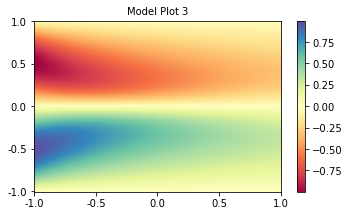

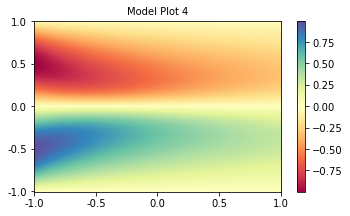

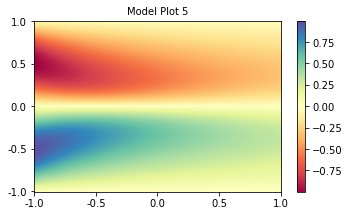

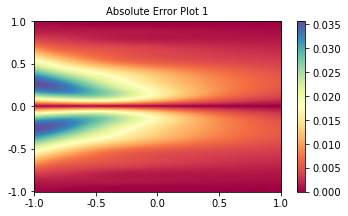

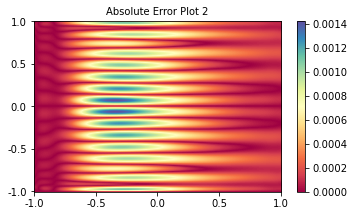

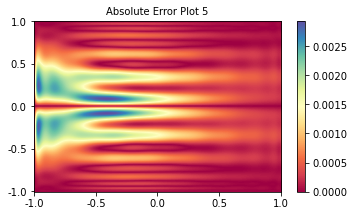

In [21]:
_ = bm.eval_model()
bm.plot_model(prefix=prefix)
bm.plot_abs_err(prefix=prefix)

#### ERROR

In [22]:
print(f'L1  Error: \n {bm.lp_err(1, precision=3)}')
print(f'L2  Error: \n {bm.lp_err(2, precision=3)}')
print(f'Max Error: \n {bm.lp_err(np.inf, precision=3)}')

L1  Error: 
 ['8.342e-03', '3.220e-04', '5.91e-04', '3.988e-04', '6.058e-04']
L2  Error: 
 ['1.184e-02', '4.435e-04', '8.775e-04', '6.838e-04', '8.967e-04']
Max Error: 
 ['3.573e-02', '1.427e-03', '2.903e-03', '3.619e-03', '2.937e-03']


#### TABLE FORMAT ERROR

In [23]:
err=np.array(
    [bm.lp_err(2, precision=2),
     bm.lp_err(np.inf, precision=2)])

row = f'{deg_d[0]} '
for _ in err.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'

print(row)

20 & 1.18e-02 & 3.57e-02 & 4.43e-04 & 1.43e-03 & 8.78e-04 & 2.90e-03 & 6.84e-04 & 3.62e-03 & 8.97e-04 & 2.94e-03 \\
